#CM4709 Computer Vision
#On-campus Day Extra Lab

##Aim
1. To load images from a CSV file of engineering drawing symbols.
1. Use CNN to classify these symbols.

##Uploading File and Mounting GoogleDrive

The symbol drawings are in a CSV file.
Upload it to a folder in GoogleDrive.
Then mount your GoogleDrive in the runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from random import randint

# imports for array-handling and plotting
import matplotlib
import os
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense


##Loading the CSV File

We can read the CSV file as a dataframe using Pandas.
The format of the CSV:
1. Each row/line in the CSV file is a data instance.
1. Each data instance has 10000 columns, followed by a label/class column. The 10000 columns represent the 100x100 image.

In [ ]:
df =pd.read_csv('/content/gdrive/MyDrive/cm4709/Lab04/data/Symbols_pixel.csv')

#show first 5 rows dataframe
#
print('===first 5 rows===')
print(df.head())

#show the columns
#
print('===columns===')
print(df.columns)

#show shape of dataframe
#
print('===shape===')
print(df.shape)


===first 5 rows===
     0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  255.7431  255.7432  \
0  255  255  255  255  255  255  255  255  255  255  ...       255         0   
1  255  255  255  255  255  255  255  255  255  255  ...         0         0   
2  255  255  255  255  255    0    0    0    0    0  ...       255       255   
3  255  255  255  255  255  255  255  255  255  255  ...         0         0   
4    0    0    0    0    0    0    0  255  255  255  ...       255       255   

   255.7433  255.7434  255.7435  255.7436  255.7437  255.7438  255.7439  \
0         0         0         0         0         0         0         0   
1         0         0         0         0       255       255       255   
2       255       255       255       255       255       255       255   
3         0         0         0         0         0         0         0   
4       255       255       255       255       255       255       255   

   Arrowhead  
0  Arrowhead  
1  Arrowhead  
2  A

##Generating Header Names

This is optional.

In [ ]:
#get no. of columns
#
num_cols=df.shape[1]

#generate header
#
rng=range(1,num_cols)
new_cols = ['p_' + str(i) for i in rng]
new_cols.append('label')
print('===new column names===')
print(new_cols)

#set column labels of dataframe
#ensure the length of the new columns list is equal to the length of df's columns
df.columns = new_cols[:num_cols]

#show first 5 rows
print('===first 5 rows===')
print(df.head())


===new column names===
['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10', 'p_11', 'p_12', 'p_13', 'p_14', 'p_15', 'p_16', 'p_17', 'p_18', 'p_19', 'p_20', 'p_21', 'p_22', 'p_23', 'p_24', 'p_25', 'p_26', 'p_27', 'p_28', 'p_29', 'p_30', 'p_31', 'p_32', 'p_33', 'p_34', 'p_35', 'p_36', 'p_37', 'p_38', 'p_39', 'p_40', 'p_41', 'p_42', 'p_43', 'p_44', 'p_45', 'p_46', 'p_47', 'p_48', 'p_49', 'p_50', 'p_51', 'p_52', 'p_53', 'p_54', 'p_55', 'p_56', 'p_57', 'p_58', 'p_59', 'p_60', 'p_61', 'p_62', 'p_63', 'p_64', 'p_65', 'p_66', 'p_67', 'p_68', 'p_69', 'p_70', 'p_71', 'p_72', 'p_73', 'p_74', 'p_75', 'p_76', 'p_77', 'p_78', 'p_79', 'p_80', 'p_81', 'p_82', 'p_83', 'p_84', 'p_85', 'p_86', 'p_87', 'p_88', 'p_89', 'p_90', 'p_91', 'p_92', 'p_93', 'p_94', 'p_95', 'p_96', 'p_97', 'p_98', 'p_99', 'p_100', 'p_101', 'p_102', 'p_103', 'p_104', 'p_105', 'p_106', 'p_107', 'p_108', 'p_109', 'p_110', 'p_111', 'p_112', 'p_113', 'p_114', 'p_115', 'p_116', 'p_117', 'p_118', 'p_119', 'p_120', 'p_1

In [ ]:
#no. of columns
#
n = df.shape[1]

#get 'label' column
#this will be y
#
labels=df['label']

#get all columns except last one
#this will be x
#
features=df.iloc[:,0:n-1]

print('===features===')
print(features)

print('===labels===')
print(labels)

In [ ]:
#show shape of x
#
print('x shape: ',features.values.shape)

#show shape of y
#
print('y shape: ',labels.values.shape)

x shape:  (2431, 10000)
y shape:  (2431,)


##Show Random Symbols

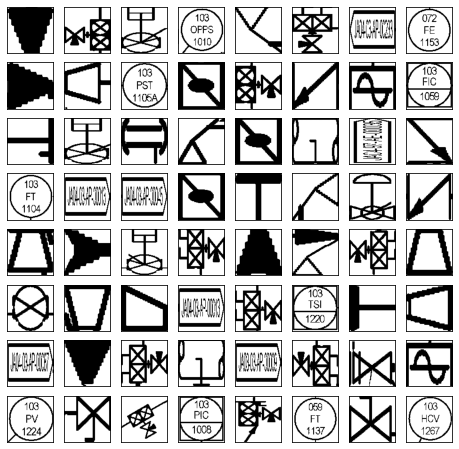

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))

#get x as an array
#
fx = features.values
print(ax.flat)

#show a number of images
#
for i, axi in enumerate(ax.flat):
  #a random index
  value = randint(0, df.shape[0])

  #get features, shape it into 100x100 and show it
  #
  axi.imshow(fx[value].reshape(100,100), cmap='gray')
  axi.set(xticks=[], yticks=[])
plt.show()

##Show Class Distribution

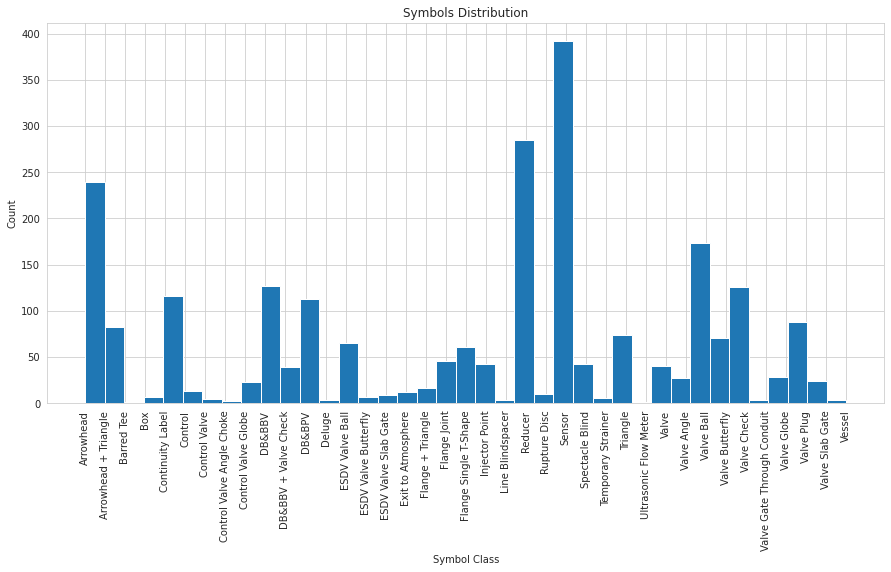

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
plt.hist(labels,bins=39)
plt.title('Symbols Distribution')
plt.xlabel('Symbol Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#show frequency/count of labels
#
df['label'].value_counts()

Sensor                        392
Reducer                       285
Arrowhead                     239
Valve Ball                    173
DB&BBV                        127
Valve Check                   126
Continuity Label              116
DB&BPV                        113
Valve Plug                     88
Arrowhead + Triangle           83
Triangle                       74
Valve Butterfly                71
ESDV Valve Ball                65
Flange Single T-Shape          61
Flange Joint                   46
Injector Point                 43
Spectacle Blind                42
Valve                          40
DB&BBV + Valve Check           39
Valve Globe                    28
Valve Angle                    27
Valve Slab Gate                24
Control Valve Globe            23
Flange + Triangle              17
Control                        13
Exit to Atmosphere             12
Rupture Disc                   10
ESDV Valve Slab Gate            9
ESDV Valve Butterfly            7
Box           

##Remove Infrequent Symbols

In [ ]:
#remove symbols with less than 7 instances
#
df = df[~df['label'].isin(['Ultrasonic Flow Meter', 'Barred Tee','Temporary Strainer',
                     'Control Valve Angle Choke','Line Blindspacer',
                     'Vessel','Valve Gate Through Conduit','Deluge','Control Valve'])]
df.values.shape
#print('shape: ',df.values.shape)
#df['label'].value_counts()

(2400, 10001)

In [ ]:
dataset = df.values
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]
print(X.shape)
print(y.shape)

(2400, 10000)
(2400,)


In [ ]:
print(f'There are {len(df.label.unique())} Unique Symbol in the dataset')

There are 30 Unique Symbol in the dataset


##Examine Datasets

In [ ]:
from sklearn.model_selection import train_test_split
# simple functions to check the shapes of all compoents of the dataset (train, test, labels)

def data_summary(X_train, y_train, X_test, y_test):
  print('Train images shape:', X_train.shape)
  print('Train labels shape:', y_train.shape)
  print('Test images shape:', X_test.shape)
  print('Test labels shape:', y_test.shape)

# split the data and check the shapes of results sets
# train_test_split(...) returns numpy arrays

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
data_summary(X_train,y_train,X_test,y_test)

Train images shape: (1920, 10000)
Train labels shape: (1920,)
Test images shape: (480, 10000)
Test labels shape: (480,)


##Reshape Data

We need to reshape the 1D array into a 2D one for the CNN.

In [ ]:
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X_test ',X_test.shape)
print('y_test ',y_test.shape)
X_train = X_train.reshape(X_train.shape[0], 100,100,1)
X_test = X_test.reshape(X_test.shape[0], 100,100,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('===AFTER RESHAPE===')
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train  (1920, 10000)
y_train  (1920,)
X_test  (480, 10000)
y_test  (480,)
===AFTER RESHAPE===
X_train  (1920, 100, 100, 1)
y_train  (1920,)
X-test  (480, 100, 100, 1)
y_test  (480,)


##Prepare Data for Model

In [ ]:
# Encode target variables
# prepare target
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train_cat = y_train
y_test_cat = y_test

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
print(y_train[0])
y_train, y_test = prepare_targets(y_train,y_test)

print('y_train ',y_train.shape)
print(y_train[0])
print('y_test ',y_test.shape)

Triangle
y_train  (1920,)
21
y_test  (480,)


##Encode Label Data

In [ ]:
from tensorflow.keras.utils import to_categorical
import keras.utils

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print('y_train ',y_train.shape)
print('y_test ',y_test.shape)
print(y_train[0])

y_train  (1920, 30)
y_test  (480, 30)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


##Validation Dataset

In [ ]:
#shuffle the training dataset (5 times!)
for _ in range(5):
    indexes = np.random.permutation(len(X_train))

X_train = X_train[indexes]
y_train = y_train[indexes]

# Keep 10% of the training data for validation
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(X_train))

# Validation set (val_data)
val_data = X_train[:val_count,:]
val_labels_cat = y_train[:val_count,:]

##Build Model

In [ ]:
def build_modelU():
  model = tf.keras.Sequential()
  # add Convolutional layers
  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Flatten())
  # Densely connected layers
  #model.add(tf.keras.layers.Dense(128, activation='relu'))
  #model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  #model.add(tf.keras.layers.Dropout(0.1))
  # output layer
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  # compile with adam optimizer & categorical_crossentropy loss function
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
  return model

model = build_modelU()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 128)       7

##Train Model

In [ ]:
nEpochs = 25
results = model.fit(X_train, y_train,
                    epochs=nEpochs, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Epoch 1/25
30/30 [==============================] - 3s 44ms/step - loss: 9.3754 - accuracy: 0.2339 - val_loss: 1.9570 - val_accuracy: 0.4375
Epoch 2/25
30/30 [==============================] - 1s 36ms/step - loss: 1.3890 - accuracy: 0.6219 - val_loss: 0.9123 - val_accuracy: 0.7969
Epoch 3/25
30/30 [==============================] - 1s 37ms/step - loss: 0.5908 - accuracy: 0.8484 - val_loss: 0.3106 - val_accuracy: 0.9115
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.2144 - accuracy: 0.9396 - val_loss: 0.1271 - val_accuracy: 0.9792
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0844 - accuracy: 0.9766 - val_loss: 0.1268 - val_accuracy: 0.9688
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0767 - accuracy: 0.9771 - val_loss: 0.0934 - val_accuracy: 0.9844
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0297 - accuracy: 0.9932 - val_loss: 0.0480 - val_accuracy: 0.9948
Epoch 8/25
30

##Plot Training History

In [ ]:
history_dict = results.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##Evaluate Model

In [ ]:
# accuracy, test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

8/8 [==============================] - 0s 15ms/step - loss: 0.2742 - accuracy: 0.9708
Test loss: 0.2742 accuracy: 0.9708


In [ ]:
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
print('Accuracy: ',sum(preds==actuals)/X_test.shape[0])

15/15 [==============================] - 0s 7ms/step
Accuracy:  0.9708333333333333


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
#print(confusion_matrix(preds,actuals))
# correctly identified symbols
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != np.argmax(y_test,axis=1)).sum())

Test accuracy: 0.9708333611488342
15/15 [==============================] - 0s 6ms/step
Incorrectly Identified Symbols:  14


In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
predictions = model.predict(X_train)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_train,axis=1)
#print(confusion_matrix(preds,actuals))
# correctly identified symbols
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != np.argmax(y_train,axis=1)).sum())

Train loss: 3.176816244376823e-05
Train accuracy: 1.0
60/60 [==============================] - 0s 6ms/step
Incorrectly Identified Symbols:  0


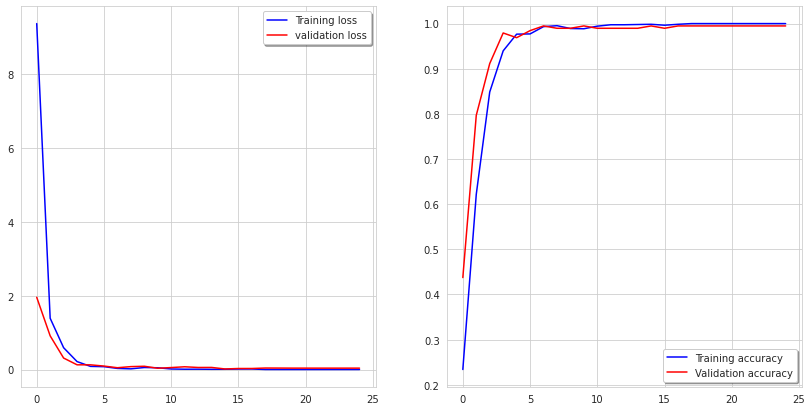

In [ ]:
# Plot the loss and accuracy curves for training and validation
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].plot(results.history['loss'], color='b', label="Training loss")
ax[0].plot(results.history['val_loss'], color='r', label="validation loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(results.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##Show Some Predictions

15/15 [==============================] - 0s 8ms/step


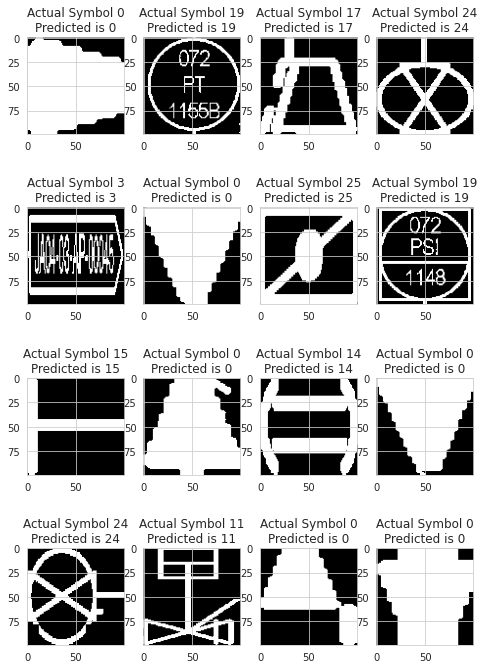

In [ ]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 100, 100)
fig, axis = plt.subplots(4, 4, figsize=(8, 12))
for i, ax in enumerate(axis.flat):
  ax.imshow(X_test__[i], cmap='binary')
  ax.set(title = f"Actual Symbol {y_test[i].argmax()}\nPredicted is {y_pred[i].argmax()}");